In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
import json
from numpyencoder import NumpyEncoder #by Hunter M. Allen (https://pypi.org/project/numpyencoder/)

param_path = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\params.txt'


We want: \
nearestrefmag\
nearestrefmagunc

In [2]:
param_df = pd.read_csv(param_path, sep=",")
columns_old = list(param_df.keys())
columns_new = [c.strip() for c in columns_old]
columns_new[0] = 'ZTF_ID'
column_dict = dict(zip(columns_old,columns_new))
param_df.rename(columns=column_dict,inplace=True)

ztf_ids = param_df['ZTF_ID'].to_numpy()


In [4]:
datapath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'
columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
dtypes = [(columns[x],float) for x in range(len(columns))]
dtypes[4] = ('filter',r'U8')
refmag_g_column,refmag_g_unc_column = [],[]
refmag_r_column,refmag_r_unc_column = [],[]

def get_refmags():
    for i,ztf in tqdm(enumerate(ztf_ids)):
        # if i == 5:
            # break
        year = ztf[3:5]
        ztfpath = os.path.join(datapath,year,ztf)
        batchrq = os.listdir(ztfpath)[0]

        unclean_data = pd.DataFrame(np.genfromtxt(os.path.join(ztfpath,batchrq),skip_header=53,dtype=dtypes))
        unclean_data = unclean_data[unclean_data['forcediffimfluxunc'] > 0] #these need to be removed or plotting doesn't work, usually not a lot of datapoints.

        filters = unclean_data['filter'].to_numpy()
        #for now we skip IR data so we only check ztf_g and ztf_r

        greenmask = filters == ['ZTF_g']
        redmask = filters == ['ZTF_r']

        #first for green
        if np.sum(greenmask) != 0: #if there is any g_data at all, otherwise set the refmag to 0 so we know it's missing here
            filterdata = unclean_data[greenmask]
            fields_g, ffreq_g = np.unique(filterdata['field'],return_counts=True)
            primary_field_g = fields_g[np.argmax(ffreq_g)]
            prim_field_mask_g = filterdata['field'] == primary_field_g
            # prim_field_mask = np.ones(prim_field_mask.shape).astype(bool)
            refmag = filterdata['nearestrefmag'][prim_field_mask_g].to_numpy()
            refmagunc = filterdata['nearestrefmagunc'][prim_field_mask_g].to_numpy()
                              
            nanmask = ~np.isnan(refmag)
            if np.sum(nanmask) == 0:
                #if the primary field does not have a defined refmag, we take the median of all other fields as our reference
                refmag_green = np.nanmedian(filterdata['nearestrefmag']) 
                idx = np.nanargmin(np.abs(filterdata['nearestrefmagunc'].to_numpy() - refmag_green)) 
                refmag_unc_green = filterdata['nearestrefmagunc'].to_numpy()[idx]
            else:
                #If there are non-nan values for the primary field we take that as the refmag
                #there still might be loads of nans however so we take a nanmean (as all values should be exactly equal)
                refmag_green = np.nanmean(refmag)
                refmag_unc_green = np.nanmean(refmagunc)

        else:
            refmag_green = 0
            refmag_unc_green = 0

        if np.sum(redmask) != 0: #same for red
            filterdata = unclean_data[redmask]
            fields_r, ffreq_r = np.unique(filterdata['field'],return_counts=True)
            primary_field_r = fields_r[np.argmax(ffreq_r)]
            prim_field_mask_r = filterdata['field'] == primary_field_r

            refmag = filterdata['nearestrefmag'][prim_field_mask_r].to_numpy()
            refmagunc = filterdata['nearestrefmagunc'][prim_field_mask_r].to_numpy()
            
            nanmask = ~np.isnan(refmag)
            if np.sum(nanmask) == 0:
                #if the primary field does not have a defined refmag, we take the median of all other fields as our reference
                refmag_unc_red = np.nanmedian(filterdata['nearestrefmag']) 
                idx = np.nanargmin(np.abs(filterdata['nearestrefmagunc'].to_numpy() - refmag_unc_red)) 
                refmag_unc_red= filterdata['nearestrefmagunc'].to_numpy()[idx]
            else:
                #If there are non-nan values for the primary field we take that as the refmag
                #there still might be loads of nans however so we take a nanmean (as all values should be exactly equal)
                refmag_red = np.nanmean(refmag)
                refmag_unc_red = np.nanmean(refmagunc)

        else:
            refmag_red = 0
            refmag_unc_red = 0

        refmag_g_column.append(refmag_green)
        refmag_g_unc_column.append(refmag_unc_green)
        refmag_r_column.append(refmag_red)
        refmag_r_unc_column.append(refmag_unc_red)

get_refmags()

0it [00:00, ?it/s]

13562it [13:22, 16.91it/s]


In [5]:
param_df['ZTF_ID'].shape[0], len(np.unique(param_df['ZTF_ID']))

(13562, 13467)

In [6]:
refmags = pd.read_csv(os.path.join(datapath,'refmags.txt'),sep='\t')
refmags

,ZTF_ID,refmag_g,refmag_unc_g,refmag_r,refmag_unc_r
0,ZTF17aaaacjo,19.165,0.020,18.907,0.019
1,ZTF17aaaazwi,21.525,0.072,21.305,0.092
2,ZTF17aaadkwx,19.451,0.043,18.594,0.046
3,ZTF17aaaduqw,22.194,0.149,21.786,0.105
4,ZTF17aaaecja,21.382,0.088,19.598,0.034
...,...,...,...,...,...
13557,ZTF23aadruim,21.083,0.086,20.295,0.054
13558,ZTF23aadsnop,19.883,0.082,19.421,0.089
13559,ZTF23aadtqpv,21.718,0.098,21.151,0.050
13560,ZTF23aadukuq,19.298,0.044,18.259,0.041


In [7]:
ids = refmags["ZTF_ID"]
dupes = refmags[ids.isin(ids[ids.duplicated()])].sort_values("ZTF_ID")
dupe_ztfs,dupe_counts = np.unique(dupes['ZTF_ID'],return_counts=True)
print(f'The following {dupe_ztfs.shape[0]} ZTF IDs appear more than once in params.txt\n', dupe_ztfs,)
print(dupe_counts)

The following 64 ZTF IDs appear more than once in params.txt
 ['ZTF17aaaacjo' 'ZTF17aaaazwi' 'ZTF17aaadkwx' 'ZTF17aaaduqw'
 'ZTF17aaaecja' 'ZTF17aaaephv' 'ZTF17aaaeqnq' 'ZTF17aaahrni'
 'ZTF17aaahzsk' 'ZTF17aaaikab' 'ZTF17aaailvv' 'ZTF17aaaivwq'
 'ZTF17aaajazz' 'ZTF17aaakeap' 'ZTF17aaakeyg' 'ZTF17aaanztg'
 'ZTF17aaapufz' 'ZTF17aaasznr' 'ZTF17aaawgzu' 'ZTF17aaazbbb'
 'ZTF17aaazdba' 'ZTF17aaazmiw' 'ZTF17aabbxwa' 'ZTF17aabhjci'
 'ZTF17aabjswn' 'ZTF17aabpwuk' 'ZTF17aabtxcs' 'ZTF17aaburzk'
 'ZTF17aabwitg' 'ZTF17aabwjsm' 'ZTF17aabzbtz' 'ZTF17aacbueo'
 'ZTF17aacdjqs' 'ZTF17aacedyd' 'ZTF17aacfeuw' 'ZTF17aachnrk'
 'ZTF17aachpzl' 'ZTF17aackjpm' 'ZTF17aaclsvt' 'ZTF17aacmbhk'
 'ZTF17aacmssc' 'ZTF17aacovcm' 'ZTF17aacovgy' 'ZTF17aacpjhi'
 'ZTF17aacshbu' 'ZTF17aactzul' 'ZTF17aacxuxc' 'ZTF17aadcejv'
 'ZTF17aaddxvj' 'ZTF17aadgmbl' 'ZTF17aadjonw' 'ZTF17aadkdks'
 'ZTF17aadqidc' 'ZTF17aaducdh' 'ZTF18aaaasts' 'ZTF18aaabauf'
 'ZTF18aaabiea' 'ZTF18aaabltn' 'ZTF18aaabsao' 'ZTF18aaacesi'
 'ZTF18aaadsda' 'ZTF18a

In [8]:
#Apparently, there's duplicates in the params file. I don't know how this happened.
refmag_df = refmags.drop_duplicates('ZTF_ID',ignore_index=True)
#Delete the instances where either g or r refmag is 0
# refmag_df = refmag_df[refmag_df['refmag_g'] != 0]
# refmag_df = refmag_df[refmag_df['refmag_r'] != 0]
refmag_df.shape

(13467, 5)

In [14]:
#Check which instances have invalid values (these should only be the cases where there is no g and/or r data for that instance)

refmag_g_column,refmag_g_unc_column = refmag_df['refmag_g'].to_numpy(),refmag_df['refmag_unc_g'].to_numpy()
refmag_r_column,refmag_r_unc_column = refmag_df['refmag_r'].to_numpy(),refmag_df['refmag_unc_r'].to_numpy()

nandices_g = np.where(refmag_g_column == 0)[0]
nandices_r = np.where(refmag_r_column == 0)[0]
nan_greens = ztf_ids[nandices_g]
nan_reds = ztf_ids[nandices_r]

print(f'green: {nan_greens}, red: {nan_reds}')
print(f'green: {nan_greens.shape[0]}, red: {nan_reds.shape[0]}')
print(np.sum(np.isin(nan_greens,nan_reds)))

print(np.sum(np.isin(dupe_ztfs,nan_greens)))
print(dupe_ztfs[np.isin(dupe_ztfs,nan_reds)])

green: ['ZTF18aaqvuhl' 'ZTF18aaxwqeq' 'ZTF18abuzqjs' 'ZTF18abvvogk'
 'ZTF18acppuui' 'ZTF19aaapmkb' 'ZTF19aalbsvu' 'ZTF19aamgzuz'
 'ZTF19aasftkm' 'ZTF19aaufakp' 'ZTF19abfiohr' 'ZTF19abfwppk'
 'ZTF19ablgxib' 'ZTF19abussea' 'ZTF19acqebea' 'ZTF19acxyrsb'
 'ZTF19adcfujy' 'ZTF20aafsmrx' 'ZTF20aamihbs' 'ZTF20abeolui'
 'ZTF20abpbfzp' 'ZTF20abpkvou' 'ZTF20abvsgdd' 'ZTF20acepkwf'
 'ZTF20aclpezy' 'ZTF20acywbes' 'ZTF21aarydyj' 'ZTF21aaydssv'
 'ZTF21abaafgm' 'ZTF21abmldwg' 'ZTF21abzdqzd' 'ZTF22aaddicw'
 'ZTF22aaddnpa' 'ZTF22aaizrty' 'ZTF22aalqnil' 'ZTF22abgwhze'], red: ['ZTF17aaburzk' 'ZTF18acalqbv' 'ZTF18aceolcv' 'ZTF18acnnzel'
 'ZTF19aanvcyp' 'ZTF20actkoic' 'ZTF21aapifhi' 'ZTF22abzjegl']
green: 36, red: 8
0
0
['ZTF17aaburzk']


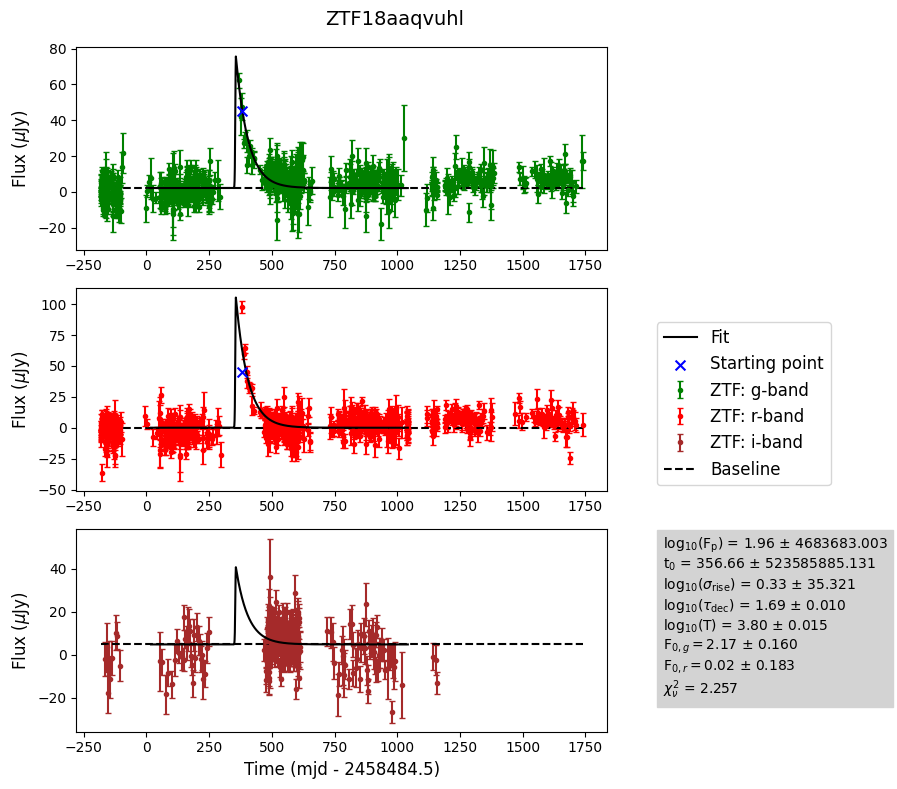

In [10]:
for ztf in nan_greens:
    year = ztf[3:5]
    yearpath = os.path.join(datapath,year)
    ztfpath = os.path.join(yearpath,ztf)
    ztfobj = fp.ZTF_forced_phot(ztf_name=ztf,ztf_dir=ztfpath)
    ztfobj.fit(plot=True)
    break

In [11]:
print(nan_greens)
print(nan_reds)

['ZTF18aaqvuhl' 'ZTF18aaxwqeq' 'ZTF18abuzqjs' 'ZTF18abvvogk'
 'ZTF18acppuui' 'ZTF19aaapmkb' 'ZTF19aalbsvu' 'ZTF19aamgzuz'
 'ZTF19aasftkm' 'ZTF19aaufakp' 'ZTF19abfiohr' 'ZTF19abfwppk'
 'ZTF19ablgxib' 'ZTF19abussea' 'ZTF19acqebea' 'ZTF19acxyrsb'
 'ZTF19adcfujy' 'ZTF20aafsmrx' 'ZTF20aamihbs' 'ZTF20abeolui'
 'ZTF20abpbfzp' 'ZTF20abpkvou' 'ZTF20abvsgdd' 'ZTF20acepkwf'
 'ZTF20aclpezy' 'ZTF20acywbes' 'ZTF21aarydyj' 'ZTF21aaydssv'
 'ZTF21abaafgm' 'ZTF21abmldwg' 'ZTF21abzdqzd' 'ZTF22aaddicw'
 'ZTF22aaddnpa' 'ZTF22aaizrty' 'ZTF22aalqnil' 'ZTF22abgwhze']
['ZTF17aaburzk' 'ZTF18acalqbv' 'ZTF18aceolcv' 'ZTF18acnnzel'
 'ZTF19aanvcyp' 'ZTF20actkoic' 'ZTF21aapifhi' 'ZTF22abzjegl']


### We now have 3 lists: duplicates and unusable instances for both g and r filter. We are going to delete these instances in both params.txt (making a new file) and in refmags.txt. 

In [15]:
refmag_df.to_csv(os.path.join(datapath,'refmags_good.txt'),index=False,sep=',')
print(f'refmag shape: {np.shape(refmag_df)[0]}')

#now, fixing the params, we do this by dropping duplicate ZTF_IDs and then only keeping the values for which there is also a refmag
param_df_drop= param_df.drop_duplicates('ZTF_ID',ignore_index=True)
param_ztfs = param_df_drop['ZTF_ID'].to_numpy()
refmag_ztfs = refmag_df['ZTF_ID'].to_numpy()
param_df_drop = param_df_drop[np.isin(param_ztfs,refmag_ztfs)]
param_df_drop.to_csv(os.path.join(datapath,'params_good.txt'),index=False,sep=',')

refmag shape: 13467
